# Import libraries

In [3]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Activation,Conv2D,MaxPooling2D,add,Dropout,Flatten,Dense
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Defining Training Data and Validation Data path

In [12]:
train_data_path = "/content/drive/MyDrive/dataset/train"
validation_data_path = "/content/drive/MyDrive/dataset/valid"

# Data Augmentation

In [4]:
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

training_data = training_datagen.flow_from_directory(train_data_path, 
                                      target_size=(224, 224), 
                                      batch_size=32,
                                      class_mode='binary')  

Found 13696 images belonging to 2 classes.


In [5]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_data = valid_datagen.flow_from_directory(validation_data_path,
                                  target_size=(224,224),
                                  batch_size=32,
                                  class_mode='binary')

Found 1606 images belonging to 2 classes.


In [ ]:
training_data.class_indices

{'with_mask': 0, 'without_mask': 1}

# Showing Augmented Images

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

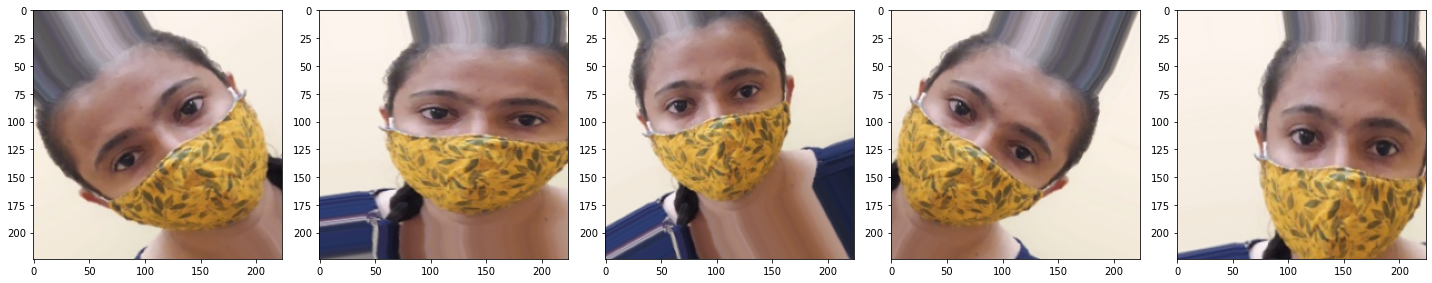

In [15]:
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

# Declaring Callbacks

In [16]:
# save best model using vall accuracy
model_path = '/content/drive/MyDrive/face_mask_model_resnet.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Creating and Training ResNet model

In [17]:
IMAGE_SIZE = [224, 224]

In [18]:
# Loading pretrained model
resnet = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

234553344/234545216 [==============================] - 1s 0us/step


In [19]:
# freezing base model weights
for layer in resnet.layers:
    layer.trainable = False

In [20]:
# our layers
x = Flatten()(resnet.output)
prediction = Dense(2, activation='softmax')(x)

In [21]:
# create a model object
cnn_model = Model(inputs=resnet.input, outputs=prediction)

In [22]:
# view the structure of the model
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.529996 to fit



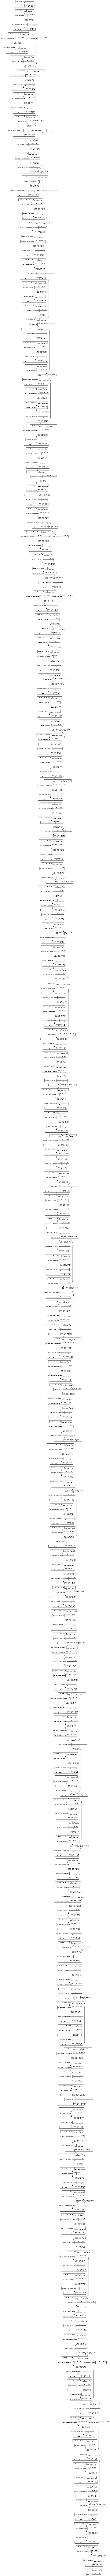

In [23]:
# plot model architecture
plot_model(cnn_model, show_shapes=True, to_file='resnet.png')

In [24]:
print(len(cnn_model.layers))

566


In [25]:
# compile cnn model
cnn_model.compile(optimizer = Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
# train cnn model
history = cnn_model.fit(training_data, 
                          epochs=100, 
                          verbose=1, 
                          validation_data= valid_data,
                          callbacks=callbacks_list)

Epoch 1/100
428/428 [==============================] - 430s 915ms/step - loss: 0.5280 - accuracy: 0.9592 - val_loss: 2.3130 - val_accuracy: 0.9303

Epoch 00001: val_accuracy improved from -inf to 0.93026, saving model to /content/drive/MyDrive/face_mask_model_resnet.h5
Epoch 2/100
428/428 [==============================] - 58s 136ms/step - loss: 0.2545 - accuracy: 0.9869 - val_loss: 4.6052 - val_accuracy: 0.9278

Epoch 00002: val_accuracy did not improve from 0.93026
Epoch 3/100
428/428 [==============================] - 57s 133ms/step - loss: 0.1842 - accuracy: 0.9977 - val_loss: 3.3661 - val_accuracy: 0.9452

Epoch 00003: val_accuracy improved from 0.93026 to 0.94521, saving model to /content/drive/MyDrive/face_mask_model_resnet.h5
Epoch 4/100
428/428 [==============================] - 58s 135ms/step - loss: 0.0576 - accuracy: 0.9974 - val_loss: 3.6548 - val_accuracy: 0.9452

Epoch 00004: val_accuracy did not improve from 0.94521
Epoch 5/100
428/428 [==============================] -

# Plotting Loss and Accuracy

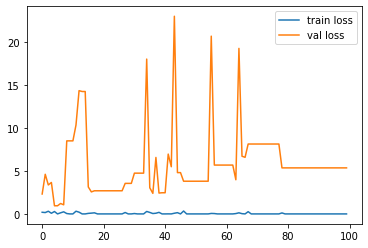

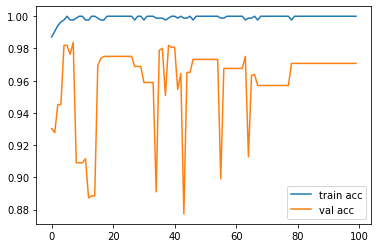

<Figure size 432x288 with 0 Axes>

In [27]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')